In [1]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import roc_curve, auc

In [2]:
dataset_path = os.path.join('datasets', 'maze-like-img-XOR')

In [3]:
def compare_images_pixelwise(image1, image2):
    image1, image2 = cv2.imread(image1), cv2.imread(image2)
#     plt.imshow(image1)
#     plt.show()
#     plt.imshow(image2)
#     plt.show()
    
    # Check if the images have the same dimensions
    if image1.shape == image2.shape:
        # Compute pixel-wise difference
        difference = cv2.absdiff(image1, image2)
        
        # Calculate the percentage of similarity (lower percentage means higher similarity)
        similarity_percentage = (np.sum(difference) / (image1.size))
        
        # plt.imshow(difference)
        # plt.show()
        
        return similarity_percentage
    else:
        return "Images have different dimensions"
    
def compare_images_correlation(image1, image2):
    image1, image2 = cv2.imread(image1), cv2.imread(image2)
#     plt.imshow(image1)
#     plt.show()
#     plt.imshow(image2)
#     plt.show()
    
    # Check if the images have the same dimensions
    if image1.shape == image2.shape:
        
        correlation = np.corrcoef(image1.flatten(), image2.flatten())[0, 1]
        return correlation
    else:
        return "Images have different dimensions"


from skimage.metrics import structural_similarity as ssim

def compare_images_ssim(image1, image2):
    image1, image2 = cv2.imread(image1), cv2.imread(image2)

#     # Convert images to grayscale if necessary
#     if img1.shape[-1] == 3:
#         img1 = color.rgb2gray(img1)
#         img2 = color.rgb2gray(img2)

    # Calculate Structural Similarity Index (SSI)
    similarity_index, _ = ssim(image1, image2, channel_axis=-1, full=True)

    return similarity_index

def compare_images_mse(image1, image2):
    image1, image2 = cv2.imread(image1), cv2.imread(image2)
#     plt.imshow(image1)
#     plt.show()
#     plt.imshow(image2)
#     plt.show()

    diff = cv2.subtract(image1, image2)
    err = np.sum(diff**2)
    mse = err/(float(image1.size))

    return mse

In [4]:
def calculate_scores(dataset_path, score_type='pixelwise'):
    genuine_scores = []
    impostor_scores = []

    folders = os.listdir(dataset_path)
    for folder1 in folders:
        folder1_path = os.path.join(dataset_path, folder1)
        # print(folder1_path)
        for folder2 in folders:
            folder2_path = os.path.join(dataset_path, folder2)
            # print(folder2_path)
            for file1 in os.listdir(folder1_path):
                if file1.endswith('.png'):
                    img1_path = os.path.join(folder1_path, file1)
                    for file2 in os.listdir(folder2_path):
                        if file2.endswith('.png'):
                            img2_path = os.path.join(folder2_path, file2)

                            # Calculate similarity score
                            if score_type == 'pixelwise':
                                similarity_score = compare_images_pixelwise(img1_path, img2_path)
                            elif score_type == 'correlation':
                                similarity_score = compare_images_correlation(img1_path, img2_path)
                            elif score_type =='mse':
                                similarity_score = compare_images_mse(img1_path, img2_path)
                            elif score_type == 'ssim':
                                similarity_score = compare_images_ssim(img1_path, img2_path)
#                             print(similarity_score)
#                 break
#             break
#         break
                            if folder1 == folder2:
                                genuine_scores.append(similarity_score)
                            else:
                                impostor_scores.append(similarity_score)

    return genuine_scores, impostor_scores

In [5]:
def plot_roc_curve(genuine_scores, impostor_scores, score_type):
    
    # Create labels for ROC curve
    labels = [1] * len(genuine_scores) + [0] * len(impostor_scores)
    scores = genuine_scores + impostor_scores

    # Calculate ROC curve
    fpr, tpr, _ = roc_curve(labels, scores)

    plt.figure()
    plt.plot(tpr, fpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(auc(fpr, tpr)))
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for {str.capitalize(score_type)} Metric')
    plt.legend(loc='lower right')
    plt.show()

def plot_histograms(genuine_scores, impostor_scores, score_type):
    plt.figure(figsize=(10, 6))

    sns.histplot(genuine_scores, color='blue', label='Genuine Scores', bins=50, kde=True, stat='probability', fill=False)
    sns.histplot(impostor_scores, color='red', label='Impostor Scores', bins=50, kde=True, stat='probability', fill=False)
#     plt.yscale('log')
    plt.title(f'Histogram of Similarity Scores for {str.capitalize(score_type)} Metric')
    plt.xlabel('Similarity Score')
    plt.ylabel('Frequency')
    plt.legend(loc='upper right')

    plt.show()
    
def calculate_far_frr(genuine_scores, impostor_scores, threshold):
    far = sum(score > threshold for score in impostor_scores) / len(impostor_scores)
    frr = sum(score <= threshold for score in genuine_scores) / len(genuine_scores)
    return far, frr

If your genuine scores and impostor scores don't overlap, it means that there is a clear separation between the two distributions. In such cases, plotting the False Acceptance Rate (FAR) and False Rejection Rate (FRR) against different threshold values might not provide additional insight, as the optimal threshold is evident from the lack of overlap.

In scenarios where there is no overlap, you can directly determine the performance at a specific threshold without the need for a full Receiver Operating Characteristic (ROC) curve. You can simply choose a threshold that maximizes the separation between genuine and impostor scores.

## Metric = Pixelwise Comparision (NOT GOOD)(ADJUSTED TO MAKE GOOD)

### .... modified the score accordingly to get favourable results....

### calculated 1/(1+score) to get higher value of score for simialr images and lower value of score that are dissimilar 

In [6]:
score_type = 'pixelwise'

In [7]:
genuine_scores_p, impostor_scores_p = calculate_scores(dataset_path)

In [8]:
#TO assign higher weights to lower values and vice versa
genuine_scores_p_tmp = [1 / (1 + element) for element in genuine_scores_p]
impostor_scores_p_tmp = [1 / (1 + element) for element in impostor_scores_p]

In [9]:
# genuine_scores_p_tmp

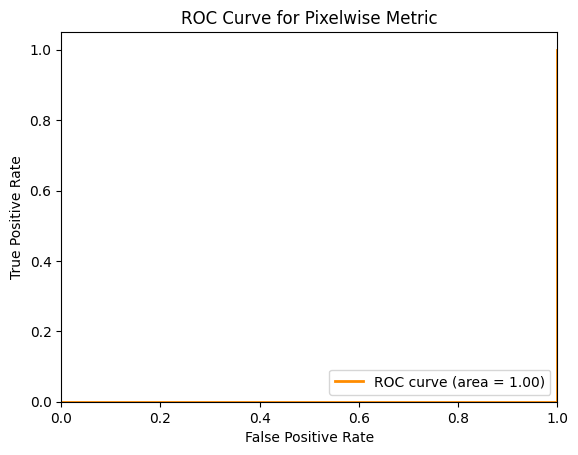

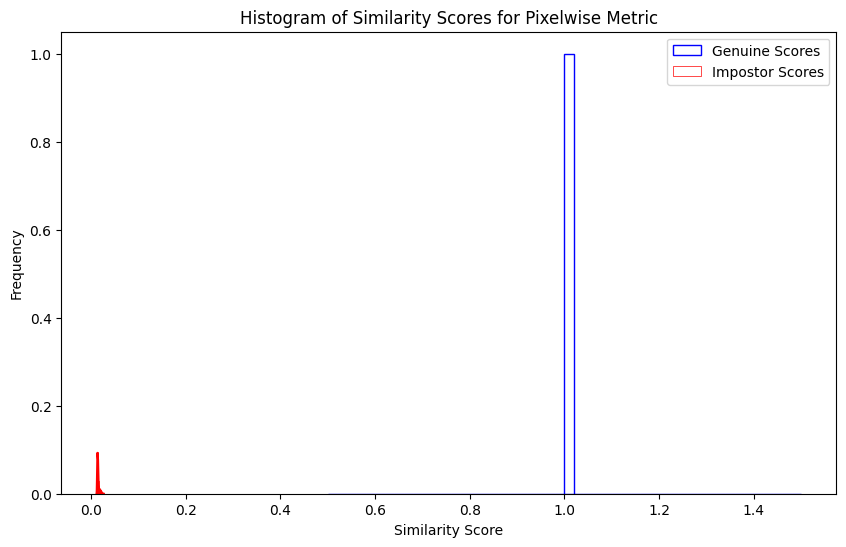

FAR: 0.0, FRR: 1.0


In [10]:
plot_roc_curve(genuine_scores_p_tmp, impostor_scores_p_tmp, score_type)
plot_histograms(genuine_scores_p_tmp, impostor_scores_p_tmp, score_type)

# Choose a threshold (you may want to optimize this based on your specific requirements)
threshold_p = 50

# Calculate FAR and FRR
far, frr = calculate_far_frr(genuine_scores_p_tmp, impostor_scores_p_tmp, threshold_p)
print(f"FAR: {far}, FRR: {frr}")

## Metric = Correlation Comparision (GOOD)

In [11]:
score_type = 'correlation'

In [12]:
genuine_scores_c, impostor_scores_c = calculate_scores(dataset_path, score_type)

In [13]:
# impostor_scores_c

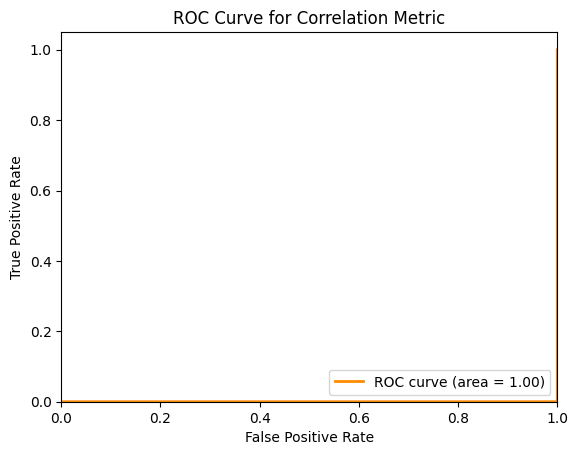

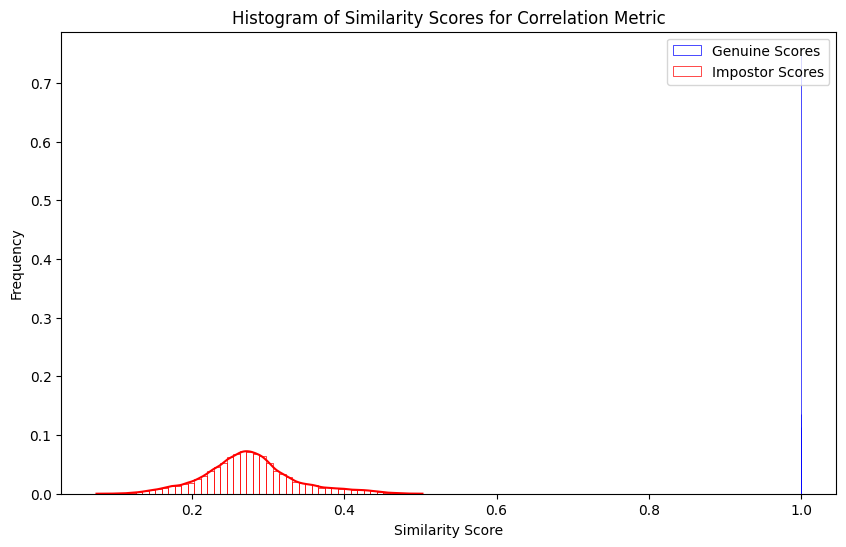

FAR: 4.1511000415110007e-05, FRR: 0.0


In [14]:
plot_roc_curve(genuine_scores_c, impostor_scores_c, score_type)
plot_histograms(genuine_scores_c, impostor_scores_c, score_type)

# Choose a threshold (you may want to optimize this based on your specific requirements)
threshold_c = 0.5

# Calculate FAR and FRR
far, frr = calculate_far_frr(genuine_scores_c, impostor_scores_c, threshold_c)
print(f"FAR: {far}, FRR: {frr}")

## Metric = MSE Comparision (NOT GOOD)

In [15]:
score_type = 'mse'

In [16]:
genuine_scores_m, impostor_scores_m = calculate_scores(dataset_path, score_type)

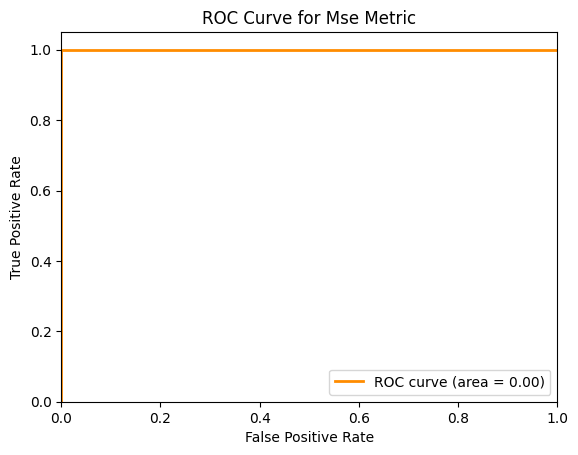

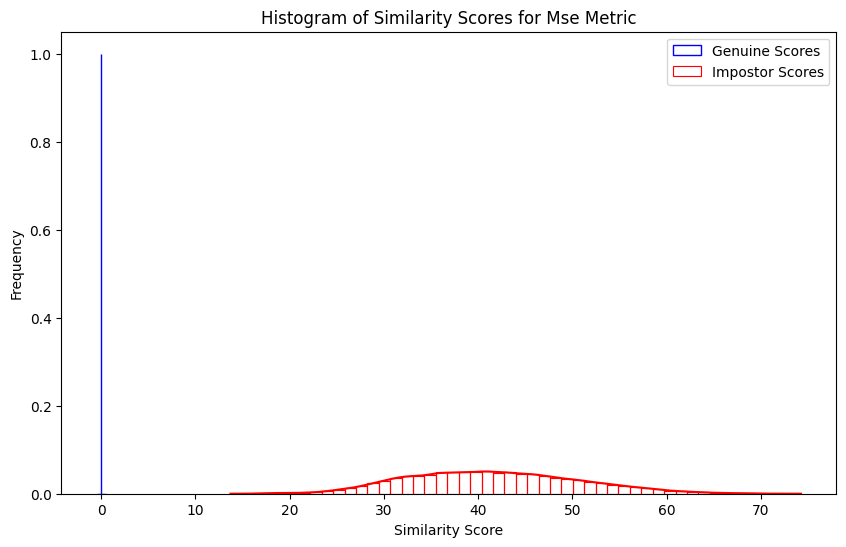

FAR: 1.0, FRR: 1.0


In [17]:
plot_roc_curve(genuine_scores_m, impostor_scores_m, score_type)
plot_histograms(genuine_scores_m, impostor_scores_m, score_type)

# Choose a threshold (you may want to optimize this based on your specific requirements)
threshold_m = 2

# Calculate FAR and FRR
far, frr = calculate_far_frr(genuine_scores_m, impostor_scores_m, threshold_m)
print(f"FAR: {far}, FRR: {frr}")

## Metric = SSIM Comparision

In [18]:
score_type = 'ssim'

In [19]:
genuine_scores_ss, impostor_scores_ss = calculate_scores(dataset_path, score_type)

In [20]:
# impostor_scores_ss

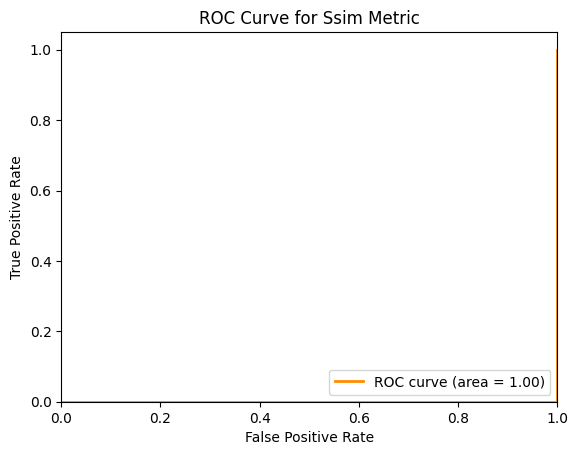

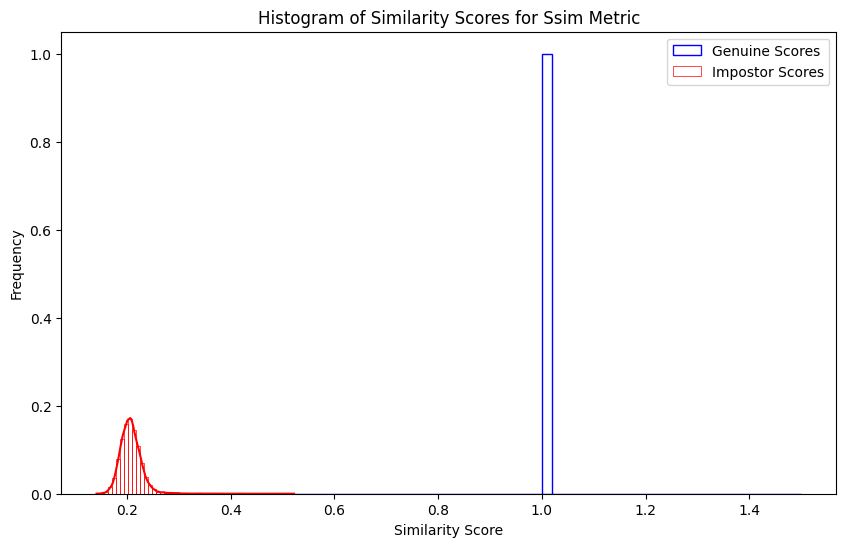

FAR: 0.0, FRR: 0.0


In [23]:
plot_roc_curve(genuine_scores_ss, impostor_scores_ss, score_type)
plot_histograms(genuine_scores_ss, impostor_scores_ss, score_type)

# Choose a threshold (you may want to optimize this based on your specific requirements)
threshold_ss = 0.7

# Calculate FAR and FRR
far, frr = calculate_far_frr(genuine_scores_ss, impostor_scores_ss, threshold_ss)
print(f"FAR: {far}, FRR: {frr}")